# Code for reproducing the results in:
## Turning Ecology Against Pesticide Resistance: Exploiting Competition in Pest Populations Through Pesticide Use

by Guariento et al.

In [15]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from tqdm import tqdm
import multiprocessing as mp
import re
import pickle
from itertools import product

In [16]:
# Format plots
sns.set(style="white",
        font_scale=1.5,
                rc={'figure.figsize':(12,6)})

# Make directory for figures
if not os.path.isdir("./figures/"):
    os.mkdir("./figures/")

In [17]:
# Define the parameters
paramDic = {"rS":.015, "rR":.015, "cRS":1., "cSR":1.,"dD":1.2, 
            "k":1., "D":0, "theta":1, 'DMax':1.5}
paramDic['dR'] = 0.2*paramDic['rR']
paramDic['dS'] = 0.2*paramDic['rS']
nTimePts = 100
dt = 1.
intervalLength = 1

def GenerateParameters(initialSize, rFrac, cost, turnover, paramDic):

    # Generate ICS
    initialStateVec = [initialSize * (1 - rFrac), initialSize * rFrac, 0, paramDic['DMax']]
    initialStateVec[2] = paramDic['theta'] * (initialStateVec[0] + initialStateVec[1])

    # Generate params   addapted for increasing competition coefficient
    paramDic = paramDic.copy()
    paramDic['cSR'] = (1+cost)*paramDic['cSR']
    paramDic['dR'] = turnover*paramDic['rR']
    paramDic['dS'] = turnover*paramDic['rS']
    return initialStateVec,paramDic

In [18]:

# --------------------------- Model -----------------------------------------------------

def lotka_volterra(t, uVec, paramDic):
    s, r, v, c = uVec
    dudtVec = np.zeros_like(uVec) 
    dudtVec[0] = paramDic['rS']*(1-paramDic['dD']*c)*(1 - (s + paramDic['cRS'] * r)/paramDic['k']) * s 
    dudtVec[1] = paramDic['rR']*(1 - (r + paramDic['cSR'] * s)/paramDic['k'])*r 
    dudtVec[2] = paramDic['theta']*(dudtVec[0] + dudtVec[1])
    dudtVec[3] = 0
    return (dudtVec)

In [19]:
 #--------------------------- Simulation -----------------------------------------------------
def Simulate_pestice_max(initialStateVec,paramDic,modelFun,t_end=None,t_span=None,t_eval=None,nTimePts=100,**kwargs):
    t_span = t_span if t_span is not None else (0, t_end)
    t_eval = t_eval if t_eval is not None else np.linspace(t_span[0],t_span[1],nTimePts)
    solObj = scipy.integrate.solve_ivp(lambda t, uVec: modelFun(t,uVec,paramDic), y0=initialStateVec,
                                       t_span=t_span,t_eval=t_eval,**kwargs)
    return pd.DataFrame({"Time": solObj.t, "S": solObj.y[0, :], "R": solObj.y[1, :],
                              "V":solObj.y[2,:], "D": solObj.y[3, :]})

def Simulate_non_int_fixed_target(initialStateVec,paramDic,modelFun,
                               rpuThreshold=0.5,intervalLength=3,refSize=None,t_end=None,t_span=None,t_eval=None,nTimePts=100,**kwargs):
    t_span = t_span if t_span is not None else (0, t_end)
    t_eval = t_eval if t_eval is not None else np.linspace(0,t_end,nTimePts)
    resultsDFList = []
    currInterval = [t_span[0],t_span[0]+intervalLength]
    refSize = initialStateVec[2] if refSize is None else refSize
    dose = initialStateVec[-1]
    currCycleId = 0
    while currInterval[1] <= t_end: 
        # Simulate
        resultsDf = Simulate_pestice_max(initialStateVec,modelFun=modelFun,
                                         paramDic=paramDic,
                                         t_span=(currInterval[0], currInterval[1]),
                                         t_eval=np.linspace(currInterval[0], currInterval[1],1000))
        resultsDf['CycleId'] = currCycleId
        resultsDFList.append(resultsDf)

        # Update dose
        if resultsDf.V.iat[-1] > refSize:
            currCycleId += (dose==0)
            dose = paramDic['DMax']
        elif resultsDf.V.iat[-1] < (1-rpuThreshold)*refSize:
            dose = 0
        else:
            dose = (dose > 0)*paramDic['DMax']
        initialStateVec = [resultsDf.S.iat[-1], resultsDf.R.iat[-1], resultsDf.V.iat[-1], dose]

        # Update interval
        currInterval = [x+intervalLength for x in currInterval]
    resultsDf = pd.concat(resultsDFList)
    # Interpolate to the desired time grid
    trimmedResultsDic = {'Time':t_eval}
    for variable in ['S','R','V','D','CycleId']:
        f =  scipy.interpolate.interp1d(resultsDf.Time,resultsDf[variable],fill_value="extrapolate")
        trimmedResultsDic = {**trimmedResultsDic,variable:f(t_eval)}
    return pd.DataFrame(data=trimmedResultsDic)

In [20]:
def ProfileProtocolStrategies(modelFun,paramDic,rpuThresholdList=[0.3, 0.5],intervalLength=0.3,dt=1.,
                               initialSizeList=np.linspace(0.25,0.75,5),
                               rFracList=[0.1,0.01,0.001],
                               PopSizeWhenProgressed=1.2,treatThreshold=0.1,enableProgressBar=True):
    tmpDicList = []
    for initialPopSize,rFrac in tqdm([(x,y) for x in initialSizeList for y in rFracList],disable=enableProgressBar==False):
        initialStateVec,_ = GenerateParameters(initialSize=initialPopSize, rFrac=rFrac, cost=0, turnover=0, paramDic=paramDic)
        maxTolerableBurden = initialPopSize*PopSizeWhenProgressed
        PopEILTreat = treatThreshold*initialPopSize

        # 0. Check that pest can progress
        rMax = np.inf
        if modelFun.__name__=='lotka_volterra':
            rMax = (1-paramDic['dR']/paramDic['rR'])*paramDic['k']
        if rMax < maxTolerableBurden:
            for strategy in ["MTD"]+[str(thresh) for thresh in rpuThresholdList]:
                tmpDicList.append({"TreatmentBranch": strategy,
                                   "RFrac": rFrac, "InitialPopSize": initialPopSize,
                                   "Treat": False, "IndefiniteControl":True, "TimeToFailure": np.nan, "RelTimeGained": np.nan,
                                   "NCycles": np.nan})
            continue

        # 1. Simulate MTD until cure or failure
        r0 = max(initialStateVec[1],0.001) # Make sure I assume at least some r0 for this calculation, otherwise it blows up
        rR = paramDic.get('rR',paramDic.get('p',0.03))
        t_end = np.log((1-r0)/(r0*(1/maxTolerableBurden-1)))/rR
        finalPopSize = 0
        treat = False
        currStateVec = initialStateVec
        currTime = 0
        
        while finalPopSize<maxTolerableBurden-1e-6 and not treat: 

            resultsDf = Simulate_pestice_max(initialStateVec=currStateVec,
                                             modelFun=modelFun,paramDic=paramDic,
                                             t_span=(currTime,t_end))
            finalPopSize = resultsDf.V.iloc[-1]
            treat = np.any(resultsDf.V<PopEILTreat)
            currStateVec = [resultsDf.S.iloc[-1], resultsDf.R.iloc[-1], resultsDf.V.iloc[-1], 1]
            currTime = t_end
            t_end *= 1.1

        
        if treat:
            tmpDicList.append({"TreatmentBranch":"MTD",
                               "RFrac": rFrac, "InitialPopSize":initialPopSize,
                               "Cured":True, "IndefiniteControl":False, "TimeToFailure":np.nan,"RelTimeGained":np.nan,
                               "NCycles":np.nan})
            continue

     
        resultsDf = Simulate_non_int_fixed_target(initialStateVec,modelFun=modelFun,
                                               paramDic=paramDic,
                                               rpuThreshold=1.,
                                               refSize=initialPopSize,
                                               intervalLength=intervalLength,
                                               t_eval=np.arange(0,t_end+dt,dt),
                                               t_end=t_end)
        timeToFailure_MTD = resultsDf.Time[resultsDf.V>maxTolerableBurden-1e-6].min() # np.abs to deal with cases when we are so close to the threshold that numerical error can cause problems
        tmpDicList.append({"TreatmentBranch":"MTD", "RFrac": rFrac, "InitialPopSize":initialPopSize,
                            "Treat":False, "IndefiniteControl":False, "TimeToFailure":timeToFailure_MTD,"RelTimeGained":np.nan,
                           "NCycles":np.nan})

        # 2. Simulate RPU
        for rpuThreshold in rpuThresholdList:
            t_end = 2*timeToFailure_MTD
            timeToFailure = np.nan
            while np.isnan(timeToFailure):
                resultsDf = Simulate_non_int_fixed_target(initialStateVec,modelFun=modelFun,
                                                       paramDic=paramDic,
                                                       rpuThreshold=rpuThreshold,
                                                       intervalLength=intervalLength,
                                                       t_eval=np.arange(0,t_end+dt,dt),
                                                       t_end=t_end)
                timeToFailure = resultsDf.Time[resultsDf.V>maxTolerableBurden-1e-6].min()
                t_end *= 1.1
            # Assess Performance
            relTimeGained = (timeToFailure-timeToFailure_MTD)/timeToFailure_MTD*100
            tmpDicList.append({"TreatmentBranch":str(rpuThreshold),
                               "RFrac": rFrac, "InitialPopSize":initialPopSize,
                               "Treat":False, "IndefiniteControl":False, "TimeToFailure":timeToFailure,
                               "AbsTimeGained":timeToFailure-timeToFailure_MTD,"RelTimeGained":relTimeGained,
                               "NCycles":resultsDf.CycleId.max()})
    return pd.DataFrame(tmpDicList)

In [25]:

# Parameterise script
intervalLength = 1.
rpuThreshold = 0.5
turnoverList = [0.2] #np.linspace(0.15, 0.2,2)
costList = np.linspace(0.05,0.5,20)
nProcesses = 2
# ------------------------ Functions ------------------------
def ProfileParamSet(paramSet):
    turnover,cost = paramSet
    paramDic = {"rS": .015, "rR": .015, "cRS": 1., "cSR": 1., "dD": 1.2,
                "k": 1., "D": 0, "theta": 1, 'DMax': 1.5}
    # Set up the parameters
    _, currParamDic = GenerateParameters(initialSize=0, rFrac=0,
                                         cost=cost, turnover=turnover,
                                         paramDic=paramDic)
    print(cost,turnover)
    # Perform the comparison
    txComparisonDf = ProfileProtocolStrategies(modelFun=lotka_volterra,paramDic=currParamDic,
                                                enableProgressBar=False,
                                                rpuThresholdList=[rpuThreshold],intervalLength=intervalLength,
                                                initialSizeList=[0.4],
                                                rFracList=np.linspace(0.001,0.01,20),
                                                PopSizeWhenProgressed=1.2,treatThreshold=1e-7)

    # Save results
    txComparisonDf['Turnover'] = turnover
    txComparisonDf['Cost'] = cost
    return txComparisonDf

# ------------------------ Main ------------------------
pool = mp.Pool(processes=nProcesses,maxtasksperchild=1)
jobList = list(product(turnoverList, costList))
tmpDicList = list(tqdm(pool.imap(ProfileParamSet,jobList),total=len(jobList)))
resultsDf = pd.concat(tmpDicList,sort=True)
resultsDf.to_csv("data.csv")

0.05 0.0736842105263158 0.2
0.2


  0%|          | 0/20 [00:00<?, ?it/s]Process ForkPoolWorker-43:
Process ForkPoolWorker-44:
Traceback (most recent call last):
  File "/opt/python/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()

  File "/opt/python/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/python/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-25-90eef0817af6>", line 18, in ProfileParamSet
    txComparisonDf = ProfileProtocolStrategies(modelFun=lotka_volterra,paramDic=currParamDic,
  File "<ipython-input-20-1e370b52a582>", line 52, in ProfileProtocolStrategies
    resultsDf = Simulate_non_int_fixed_target(initialStateVec,modelFun=modelFun,
Traceback (most recent call last):
  File "/opt/python/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "<ipython-input-19-d61219611533>", line 29, in Simulat

KeyboardInterrupt: KeyboardInterrupt: 

In [23]:
ComparisonDf = pd.read_csv("data.csv",index_col=0)

<ipython-input-24-c7237a7c40f3>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  timeToFailureMat = tmpDf.pivot("Cost","RFrac","AbsTimeGained")


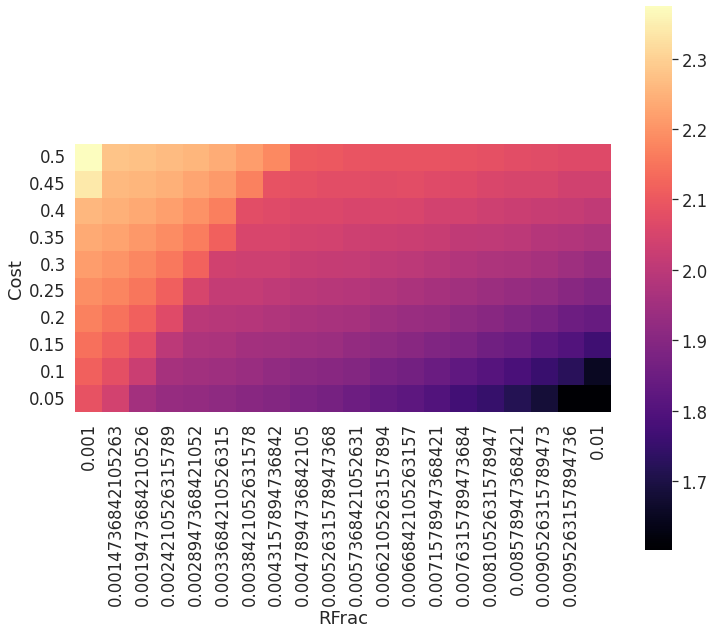

In [24]:
# Reshape into a matrix
tmpDf = ComparisonDf.loc[ComparisonDf.TreatmentBranch=="0.5",["Cost","RFrac","AbsTimeGained"]].reset_index(drop=True)
tmpDf['Cost'] *= 1
tmpDf['RFrac'] *= 1
tmpDf['AbsTimeGained'] = np.log10(tmpDf['AbsTimeGained'])
#tmpDf.sortlevel(["Cost"], ascending=[False], sort_remaining=False)
timeToFailureMat = tmpDf.pivot("Cost","RFrac","AbsTimeGained")
timeToFailureMat.sort_index(level="Cost",ascending=False,inplace=True)


# Plot
fig, ax = plt.subplots(1,1,figsize=(12,10))

g = sns.heatmap(data=timeToFailureMat,cmap='magma',square=True,cbar=True,ax=ax)
plt.savefig("myimg.svg")